In [45]:
import numpy as np
import rebound
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict

In [46]:
def wrapRad(theta):
    return (theta + np.pi) % (2*np.pi) - np.pi

$$ r = \frac{j_2}{j_1},\qquad 
\epsilon_1 = \mu_1 |C_1| e^{k_1},\qquad
\epsilon_2 = \mu_2 |C_2| e^{k_2}, \qquad
\nu = \frac{1}{\sqrt{3}}\frac{n_{r2}-n_{r1}}{n_{r1}} = \frac{1}{\sqrt{3}}\left(\frac{j_1(j_2+k_2)}{j_2(j_1-k_1)}\frac{n_2}{n_1}-1\right)$$

In [47]:
def calculateParam(ecc, j1, k1, j2, k2, P1, P2, mu1, mu2):
    # get r
    r = j2/j1

    # calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get e1 and e2
    epsilon1 = mu1 * abs(Cval1) * ecc**k1
    epsilon2 = mu2 * abs(Cval2) * ecc**k2

    # get nu
    n1 = 2*np.pi/P1
    n_r1 = (j1-k1) * n1 / j1
    n2 = 2*np.pi/P2
    n_r2 = (j2+k2) * n2 / j2
    nu = 1/np.sqrt(3) * (n_r2/n_r1 - 1)
    
    return r, nu, epsilon1, epsilon2

In [48]:
def calculateIC(P_0, lambda_0):
    # get p_0 and lambda_0
    phi_0 = wrapRad(j1* lambda_0)
    p_0 = -np.sqrt(3) * ((n_r1 / (2*np.pi/P_0))**(1/3) - 1)
    
    return phi_0, p_0

In [80]:
# user-defined parameters
ecc, j1, k1, j2, k2 = 0.2, 3, 1, 5, 1
P1, P2 = 1, 1.2
mu1, mu2 = 7e-3, 8e-3

r, nu, epsilon1, epsilon2 = calculateParam(ecc, j1, k1, j2, k2, P1, P2, mu1, mu2)

print(r, nu, epsilon1, epsilon2)
print(2*np.sqrt(epsilon1), 2*np.sqrt(epsilon2))

1.6666666666666667 0.2886751345948129 0.0034776072566255183 0.007129828456094287
0.11794248185663245 0.16887662308436047


In [60]:
# user-defined initial conditions (P_0, lambda_0)
ic = [[x,y] for x in np.linspace(1.1, 1.22, 10) for y in np.linspace(-np.pi/20, np.pi/20, 5)]

In [61]:
# fig = rebound.OrbitPlot(sim, unitlabel='[AU]')

KeyboardInterrupt: 

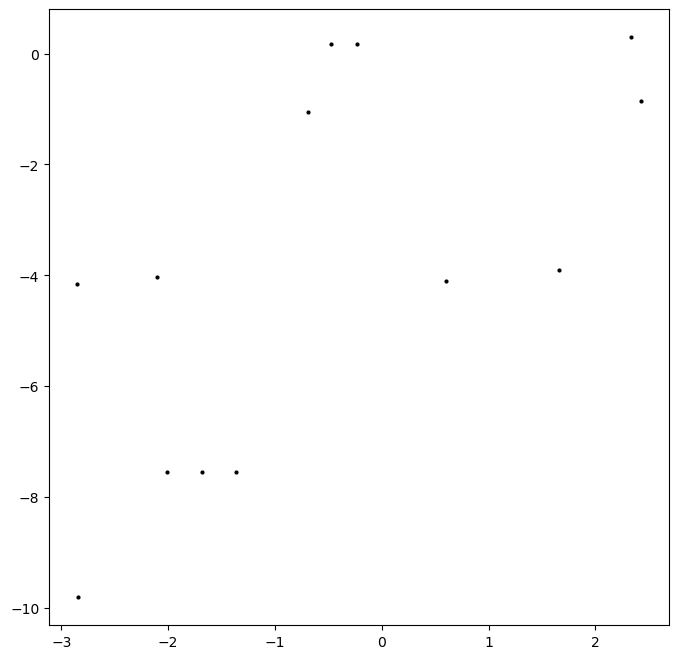

In [62]:
for P_0, lambda_0 in ic:
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(primary=sim.particles[0], m=mu1, P=P1)
    sim.add(primary=sim.particles[0], m=mu2, P=P2)

    # add test particle
    sim.add(primary=sim.particles[0], P=P_0, l=lambda_0, e=ecc)
    

    # track how system developes in time
    num = 11
    time = np.linspace(0,num-1,num)*2*np.pi/(r*nu)

    n_r1 = (j1-k1) * 2*np.pi / (j1*P1)
    n_r2 = (j2+k2) * 2*np.pi / (j2*P2)

    for t in time:
        sim.integrate(t)
        info = sim.particles[3].calculate_orbit(primary=sim.particles[0])
        
        phi = wrapRad(j1*(info.l - n_r1*t))
        p = -np.sqrt(3)*((n_r1 / info.n)**(1/3) - 1)
        plt.scatter(phi,p,[4],color='black')
        
#         print(info.l, 2*np.pi/info.n)

plt.show()

In [72]:
def hamilton(y,t,e1,e2,r,nu):
    phi, p = y
    dydt = [p, -e1*np.sin(phi) - r*e2*np.sin(r*(phi-nu*t))]
    return dydt

In [81]:
def phasePlot(e1, e2, r, nu, ic):
    num = 101  # number of sampled time
    t = np.linspace(0,num-1,num)*2*np.pi/(r*nu)
    
    plt.rcParams["figure.figsize"] = (8,8)
    for y0 in ic:
        sol = odeint(hamilton, y0, t, args=(e1,e2,r,nu))
        phi = (sol[:,0] + np.pi * np.ones(num)) % (2*np.pi) - np.pi * np.ones(num)  # wrap into [-pi,pi]
        plt.plot(phi, sol[:,1], 'k.', ms=0.2)
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$p$')
    plt.title(fr'phase-space plot for $\nu={nu}$')
    plt.show()

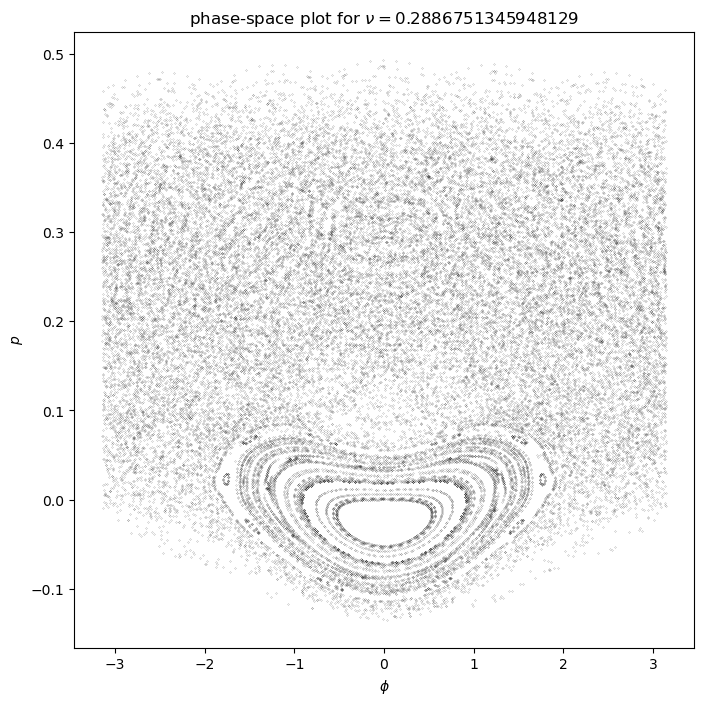

In [82]:
ic = [[x,y] for x in np.linspace(-np.pi/2, np.pi/2, 20) for y in np.linspace(0, 0.4, 20)]
phasePlot(epsilon1, epsilon2, r, nu, ic)